In [27]:
import pandas as pd
import numpy as np

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

LOAD FILE AND GET THE CORRECT DATAFRAME

In [3]:
df = pd.read_csv('igeni.csv')

In [4]:
df_volumn = df[df['Unidad de medida'] == 'Índice de volumen físico base 2013=100'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()
df_acc_volumn = df[df['Unidad de medida'] == 'Índice de volumen físico acumulado base 2013=100'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()
df_percent = df[df['Unidad de medida'] == 'Variación porcentual del índice de volumen físico'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()
df_acc_percent = df[df['Unidad de medida'] == 'Variación porcentual del índice de volumen físico acumulado'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()

In [38]:
df_volumn.head()

,index,Periodo,Valor
0,1340,1993/01,48.100864
1,1339,1993/02,48.733164
2,1338,1993/03,46.038430
3,1337,1993/04,48.742361
4,1336,1993/05,50.833388


<AxesSubplot: xlabel='Periodo'>

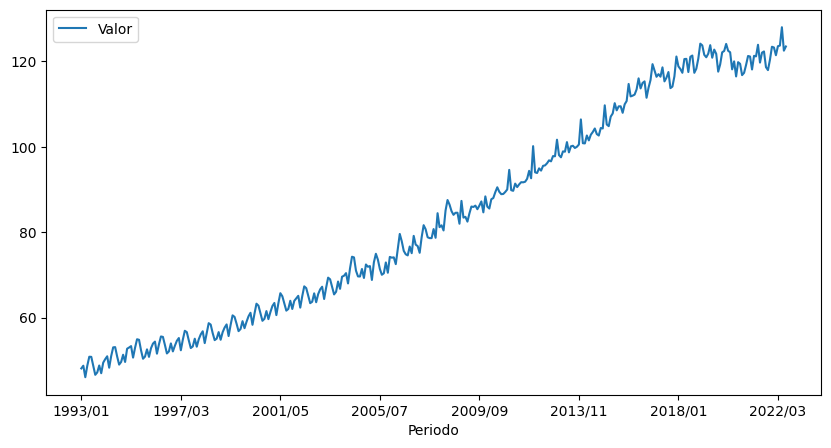

In [44]:
df_volumn.plot('Periodo', 'Valor', kind ='line', figsize=(10,5))

THE VALOR LOOKS WITH A CLEAN INCREASE TREND, SO IT IS NOT STATIONARY.
AND IT HAS A SEASONAL PATTERN

# Perform statistical tests of stationarity and decide the type of transformation of the variable

WE USE THE SEASONAL DIFFERENCE OF THE LOG OF SERIES, CHECK MONTHLY, QUARTERLY AND ANNUAL DIFFERENCE

In [6]:
df = df_volumn.copy()
df['diff_monthly'] = np.log(df['Valor']) - np.log(df['Valor'].shift(1))
df['diff_quater'] = np.log(df['Valor']) - np.log(df['Valor'].shift(3))
df['diff_annual'] = np.log(df['Valor']) - np.log(df['Valor'].shift(12))

TEST D=2

In [74]:
#df['dd_monthly'] = np.log(df['Valor']) - 2 * np.log(df['Valor'].shift(1)) + np.log(df['Valor'].shift(2))

In [73]:
#df.plot('Periodo', ['diff_monthly', 'diff_quater', 'diff_annual', 'dd_monthly'], kind = 'line', figsize=(12,5))

In [72]:
#fig, axs = plt.subplots(2, 1, figsize=(12,4))
#plot_acf(df['dd_monthly'].dropna().tolist(), lags = 40, ax = axs[0])
#plot_pacf(df['dd_monthly'].dropna().tolist(), lags = 40, method='ywm', ax = axs[1])
#fig.suptitle('Monthly DD')
#fig.tight_layout()
#plt.show()

<AxesSubplot: xlabel='Periodo'>

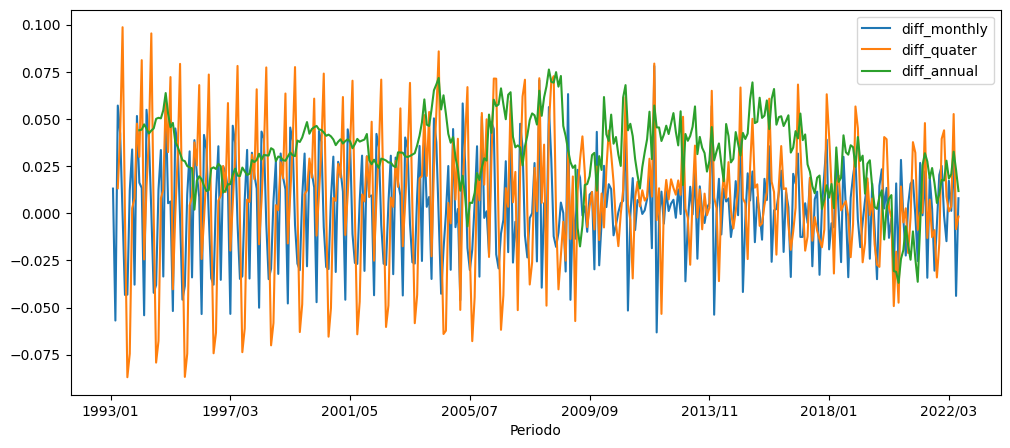

In [46]:
df.plot('Periodo', ['diff_monthly', 'diff_quater', 'diff_annual'], kind = 'line', figsize=(12,5))

In [36]:
#df.head(24)

In [30]:
list_diff_quarter = df['diff_quater'].dropna().tolist()
list_diff_monthly = df['diff_monthly'].dropna().tolist()
list_diff_annual = df['diff_annual'].dropna().tolist()

In [8]:
from statsmodels.tsa.stattools import adfuller

USE DICKY FULLER TER TO CHECK THE STATIONARY OF THE SEASON DATA, TO CHECK THE SEASONALITY

In [35]:
#adfuller(df['Valor'].tolist())

In [32]:
adfuller(list_diff_monthly)

(-3.6440485223843444,
 0.004972651961633321,
 13,
 340,
 {'1%': -3.4497304638968043,
  '5%': -2.8700785273763487,
  '10%': -2.571319005190311},
 -2132.7923974274536)

In [33]:
adfuller(list_diff_quarter)

(-3.692815564239722,
 0.00421535207618755,
 11,
 340,
 {'1%': -3.4497304638968043,
  '5%': -2.8700785273763487,
  '10%': -2.571319005190311},
 -2116.756442184382)

In [34]:
adfuller(list_diff_annual)

(-3.4476057501271464,
 0.009439170431343487,
 12,
 330,
 {'1%': -3.4503224123605194,
  '5%': -2.870338478726661,
  '10%': -2.571457612488522},
 -2082.2581392100105)

P VALUE OF THE ORIGINAL VALUE IS 0.96, MUCH MORE THAN 0.05, SO THE ORIGINAL VALUE IS NON-STATIONARY.

P VALUE OF THE DIFF_MONTHLY, DIFF_QUATER, DIFF_ANNUAL ARE ALL LESS THAN 0.05, SO THEY ARE ALL STATIONARY.

WE WILL CONTINUE TO CHECK TO CALIBRATE AN ARIMA-SARIMA MODEL

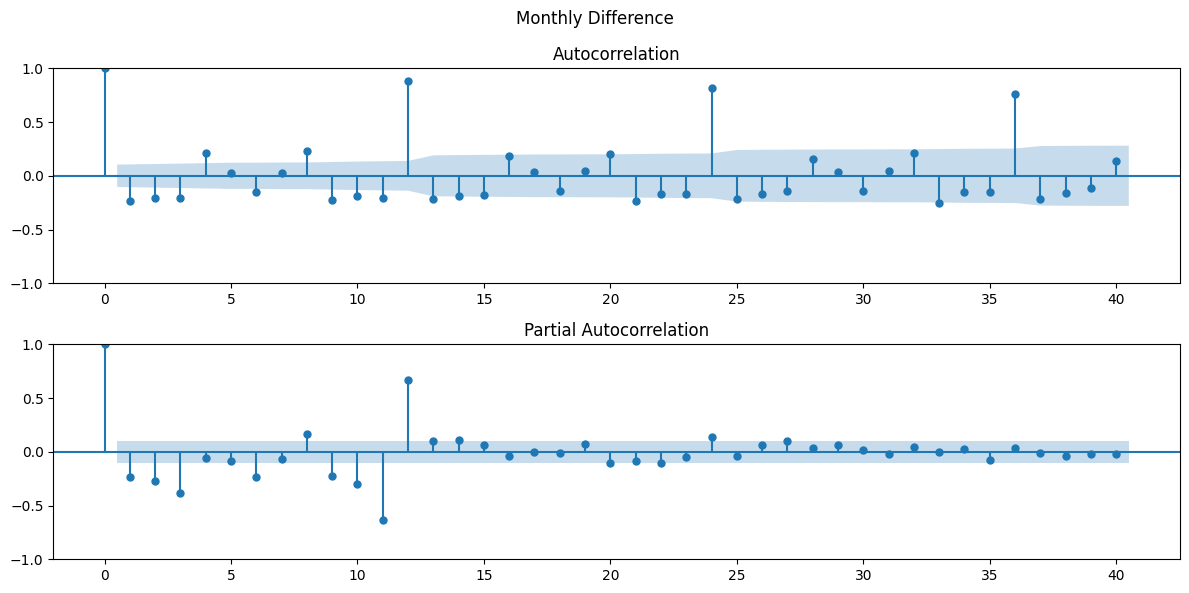

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(12,6))
plot_acf(list_diff_monthly, lags = 40, ax = axs[0])
plot_pacf(list_diff_monthly, lags = 40, method='ywm', ax = axs[1])
fig.suptitle('Monthly Difference')
fig.tight_layout()
plt.show()


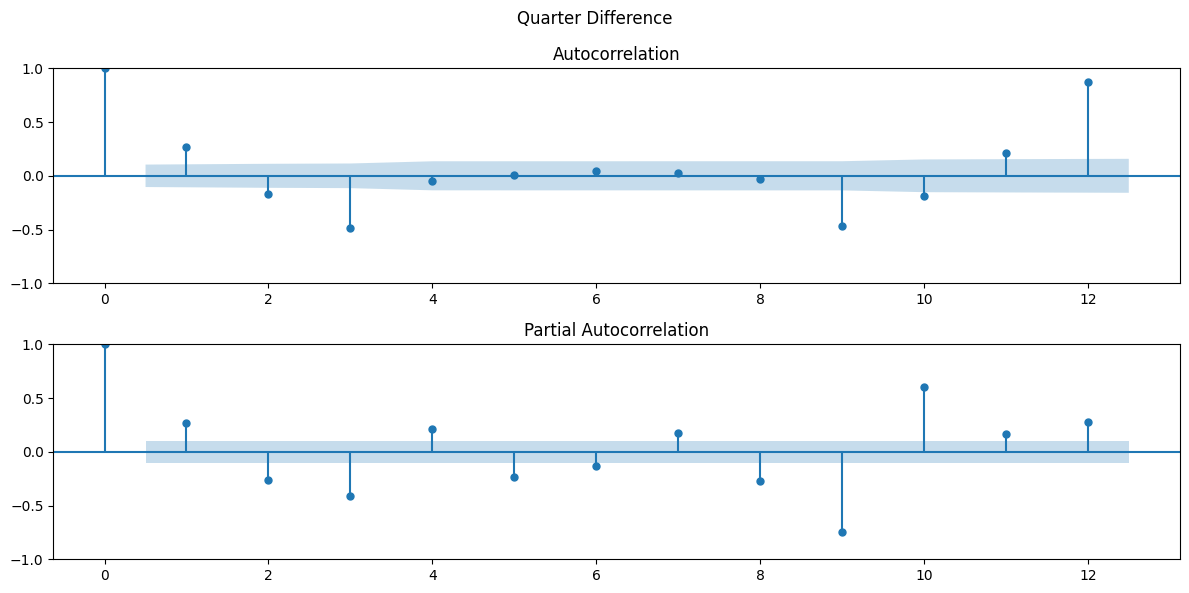

In [78]:
fig, axs = plt.subplots(2, 1, figsize=(12,6))
plot_acf(list_diff_quarter, lags = 12, ax = axs[0])
plot_pacf(list_diff_quarter, lags = 12, method='ywm', ax = axs[1])
fig.suptitle('Quarter Difference')
fig.tight_layout()
plt.show()

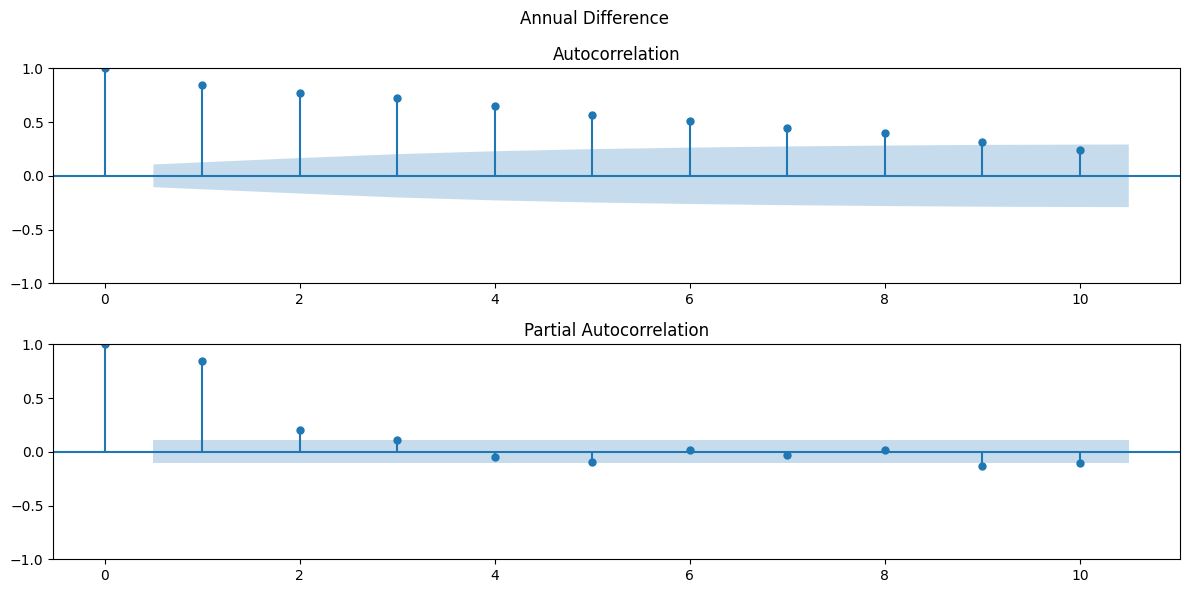

In [79]:
fig, axs = plt.subplots(2, 1, figsize=(12,6))
plot_acf(list_diff_annual, lags = 10, ax = axs[0])
plot_pacf(list_diff_annual, lags = 10, method='ywm', ax = axs[1])
fig.suptitle('Annual Difference')
fig.tight_layout()
plt.show()

CHECK THE **ANNUAL DIFFERENCE** PLOT.
IN **ACF** PLOT, WE SEE FIRST 8 AC ARE POSITIVE AND SIGNIFICANT,
AND THEY **GRADUALLY DECAY**.

AC OF LAG1 IS ABOUT 80%
THIS MEANS THE ANNUAL %GROWTH OF THE MEXICO FINANCE VOLUME IS STRONGLY CORELATED(WITH A CORRELACTION OF 80%) 
WITH ITS OWN ANNUAL %GROWTH OF THE PREVIUOS MOTH (ITS LAG 1)

THE AC OF LAG 2 IS ABOUT 70%, 
THIS MEANS THAT ANNUAL %GROWTH OF MEXICO FINANCE IS STRONGLY CORRELATED(WITH A CORRELATION OF 70%)
WITH ITS OWN ANNUAL %GROWTH OF 2 MONTHS AGO(ITS LAG 2)

IN THE CASE OF **PACF**,
SHOWS ONLY THE FIRST 2 AUTOCORRELATIONS TO BE POSITIVE AND SIGNIFICANT,
AND THE MAGNITUDE OF THE FOLLOWING AUTOCORRELATIONS **GOES DOWN TO ZERO OR NEGATIVE VERY QUICKLY**.

WHEN THE **ACF** PLOT SHOWS A **SLOW DECLIEN** OF AUTOCORRELATIONS,
AND THE **PACF** SHOWS A **FAST DECLINE** OF AUTOCORRELATIONS,
THIS IS A CLEAR **PATTERN OF AN AR(P) MODEL**.

IN THIS CASE, THE NUMBER OF AR TERMS IS DETERMINED BY THE SIGNIFICANT LAGS IN THE PACF PLOT(WHICH IS 2 LAG)

WE START WITH AR(2) MODEL
WITH AN ARIMA WITH P=2 AND Q=0

## ESTIMATE THE ARIMA-SARIMA MODEL

WE DEFINE THE MODEL AS
ARIMA(p,d,q) SARIMA(P,D,Q,#period in the year)
IN OUR EXAMPLE, THE VALUE FOR PARMETER ARE
ARIMA(2, 0, 0) SARIMA(0, 1, 0, 12)

1, **NUMBER OF PERIOD IS 12 IN A YEAR**, SO OUR SERIES SHOULD BE MONTHLY

2, d = 0, and D = 1
**D = 1**, THIS MEAN THAT WE ARE MODELING THE SEAONAL DIFFERENCE(D=1) OF THE VRAIBLE, WHICH IS THE ANNUAL %GROWTH(MONTH BY MONTH)
**d = 0**, THIS MEANS THAT WE ARE **NOT** USING THE FIRST DIFFERENCE OF THE SERIES.

[ln(Y_t) - ln(Y_(t-12))]

3, **p = 2**, MODEL INCLUDES THE FIRST 2 AR TERMS
**q = 0**, MODEL DO NOT INCLUDE MA TERMS
**P = 0**, MODEL DO NOT INCLUDE SEASONAL AR TERMS
**Q = 0**, MODEL DO NOT INCLUDE SEASONAL MA TERMS

BY MATH NOTION
**s12.lnairt=ϕ0+ϕ1L1.s12.lnairt+ϕ2L2.s12.lnairt+εt**

IT MEANS
THE ANNUAL %GROWTH(MONTH BY MONTH) OF MEXICO FINANCE VOLUME AT TIME T CAN BE DETERMINED BY ITS OWN ANNUAL %GROWTH OF MEXICO FINANCE VOLUME AT TIME T-1 AND T-2(THE %GROWTH OF THE PREVIOUS 2 MONTHS), AND BY A RANDOM SHOCK

## RUNNING THE ARIMA/SARIMA 

In [80]:
ar_model = AutoReg(list_diff_annual, lags = 2).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  343
Model:                     AutoReg(2)   Log Likelihood                1084.716
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Thu, 03 Nov 2022   AIC                          -2161.431
Time:                        20:07:36   BIC                          -2146.104
Sample:                             2   HQIC                         -2155.325
                                  343                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.486      0.000       0.002       0.006
y.L1           0.6797      0.053     12.779      0.000       0.575       0.784
y.L2           0.1992      0.053      3.746      0.000       0.095       0.303
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1101           +0.0000j            1.1101            0.0000
AR.2           -4.5221           +0.0000j            4.5221            0.5000
-----------------------------------------------------------------------------
"""

# Calibrates an ARIMA-SARIMA model based on autocorrelation tests and plots. It clearly explains the calibration process and the reason for how it changes the parameters.

# Interpret the coefficients and their statistical significance of the calibrated model

# It makes a prediction of the variable using the calibrated model.